# Численные методы решения дифференциальных уравнений с частными производными.

In [1]:
import math
import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt

Вспомогательные константы и функции

In [2]:
! make compile

g++ -g -O2 -pedantic -std=c++17 -Wall -Wextra -Werror main.cpp -o solver


In [3]:
EPS = 1e-9

def neq(x, y):
    return True if np.abs(x - y) > EPS else False

def write_arr(file, arr):
    file.write(" ".join(str(elem) for elem in arr) + "\n")

### Ввод данных

Критерий КФЛ (критерий Куранта-Фридрихса-Леви)

In [4]:
sigma = 0.5

Используемый численный метод

* $\theta = 0$ - явный метод
* $\theta = {1 \over 2}$ - комбинированный метод Кранка-Николсона
* $\theta = 1$ - неявный метод

In [5]:
theta = 0.5

Как обрабатывать граничные условия

* $boundary = 1$ - $O(\tau + h)$, 2 точки, 1 порядок
* $boundary = 2$ - $O(\tau + h ^ 2)$, 3 точки, 2 порядок
* $boundary = 3$ - $O(\tau + h ^ 2)$, 2 точки, 2 порядок

In [6]:
boundary = 3

Ограничения по $x$ и $t$, параметр сетки.

$x \in [0, l]$, $t \in [0, T]$

In [7]:
l = np.pi
n = 100
T = 2

Коэффициенты уравнения

In [8]:
a = 1
b = 1
c = -1

Коэффициенты в граничных условиях

In [9]:
alpha_0 = 1
beta_0 = 1

alpha_l = 1
beta_l = 1

Граничные условия

In [10]:
def u0(x):
    return np.sin(x)

def gamma_0(t):
    return np.exp((c - a) * t) * (np.cos(b * t) + np.sin(b * t))

def gamma_l(t):
    return -np.exp((c - a) * t) * (np.cos(b * t) + np.sin(b * t))

Точное решение

In [11]:
def true_u(x, t):
    return np.exp((c - a) * t) * np.sin(x + b * t)

### Препроцессинг

Вычисление шагов $h$ и $\tau$

In [12]:
K = math.ceil((T * a * n * n) / (l * l * sigma))

h = l / (n - 1)
tau = T / (K - 1)

t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

Генерация узлов сетки

In [13]:
t = [k * tau for k in range(K - 1)]
t.append(T)
t = np.array(t)

x = [i * h for i in range(n - 1)]
x.append(l)
x = np.array(x)

Генерация начальных условий для решателя

In [14]:
bound_0t = []
bound_x0 = []
bound_lt = []

for i in range(n):
    bound_x0.append(u0(x[i]))

for k in range(K):
    bound_0t.append(gamma_0(t[k]))
    bound_lt.append(gamma_l(t[k]))

with open("in.txt", "w") as file_in:
    write_arr(file_in, [n, K, boundary])
    write_arr(file_in, [l, T, h, tau, theta])
    write_arr(file_in, [a, b, c])
    write_arr(file_in, [alpha_0, beta_0, alpha_l, beta_l])
    write_arr(file_in, bound_x0)
    write_arr(file_in, bound_0t)
    write_arr(file_in, bound_lt)

### Решение

In [15]:
! ./solver < in.txt > out.txt

### Постпроцессинг

In [16]:
data = []

with open("out.txt", "r") as file_out:
    for _ in range(K):
        file_line = file_out.readline()
        data_line = [float(elem) for elem in file_line.split()]
        data.append(data_line)

data = np.array(data)

### Визуализация

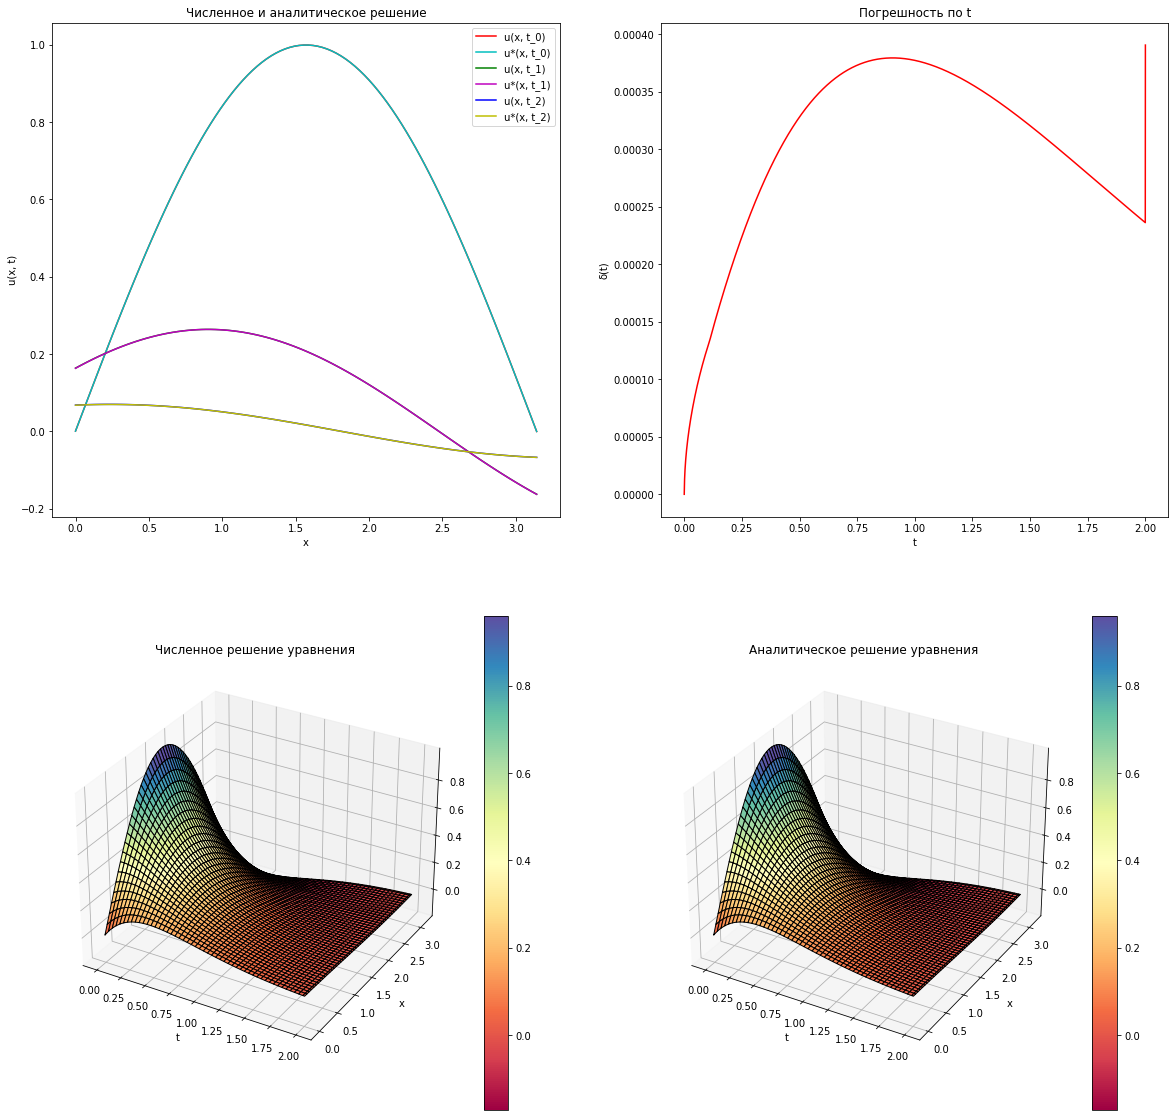

In [17]:
def subplot3d(ind, figure, x, y, z):
    axes = figure.add_subplot(ind, projection = "3d")
    surface = axes.plot_surface(x, y, z, edgecolors = ["black"], linewidth = 1,
                                cmap = matplotlib.cm.Spectral, shade = True, antialiased = True)
    figure.colorbar(surface)

figure = plt.figure(figsize = (20, 20))
x_plt, t_plt = np.meshgrid(x, t)
true_data = true_u(x_plt, t_plt)
ind = [1, K // 3, 2 * K // 3]
delta = np.abs(data - true_data)

axes = figure.add_subplot(221)
clrs = ["r", "g", "b"]
clrs_true = ["c", "m", "y"]
for (i, elem) in enumerate(ind):
    axes.plot(x, data[elem], color = clrs[i], label = "u(x, t_" + str(i) + ")")
    axes.plot(x, true_data[elem], color = clrs_true[i], label = "u*(x, t_" + str(i) + ")")
plt.legend()
plt.title("Численное и аналитическое решение")
plt.xlabel("x")
plt.ylabel("u(x, t)")

axes = figure.add_subplot(222)
axes.plot(t, np.max(delta, axis = 1), color = "red")
plt.title("Погрешность по t")
plt.xlabel("t")
plt.ylabel("δ(t)")


subplot3d(223, figure, t_plt, x_plt, data)
plt.title("Численное решение уравнения")
plt.xlabel("t")
plt.ylabel("x")

subplot3d(224, figure, t_plt, x_plt, true_data)
plt.title("Аналитическое решение уравнения")
plt.xlabel("t")
plt.ylabel("x")

plt.show()